In [58]:
import numpy as np
import pandas as pd
import scipy.stats

import itertools
from collections import OrderedDict

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.75)

In [62]:
def iterator__product_of_dict_values(**kwargs):
    ''' Given a dict whose values are lists, return iterator over products
    
    Returns
    -------
    my_iterator : iterator
    
    Examples
    --------
    >>> my_grid = {'a':[1,2,3], 'fruit':['pear', 'orange']}
    >>> _ = [print(a) for a in iterator__product_of_dict_values(my_grid)]
    OrderedDict([('a', 1), ('fruit', 'pear')])
    OrderedDict([('a', 1), ('fruit', 'orange')])
    OrderedDict([('a', 2), ('fruit', 'pear')])
    OrderedDict([('a', 2), ('fruit', 'orange')])
    OrderedDict([('a', 3), ('fruit', 'pear')])
    OrderedDict([('a', 3), ('fruit', 'orange')])
    '''
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in itertools.product(*vals):
        yield OrderedDict(zip(keys, instance))

# Load in data

In [64]:
df = pd.read_csv('fakeresults_accuracy_vs_amount_and_source_of_train_data.csv')

In [65]:
df.head()

,classifier_nickname,phases,n_generic_subjects_used_for_training,frac_of_target_subject_data_used_for_training,acc_at_10th,acc_at_25th,acc_at_50th,acc_at_75th,acc_at_90th
0,CNN,1+2,4,0.000,0.5726,0.6169,0.6648,0.7106,0.7498
1,CNN,1+2,16,0.000,0.5869,0.6302,0.6771,0.7219,0.7593
2,CNN,1+2,64,0.000,0.6175,0.6585,0.7024,0.7443,0.7792
3,CNN,1+2+3,4,0.125,0.7430,0.7889,0.8345,0.8744,0.9048
4,CNN,1+2+3,4,0.250,0.7607,0.8053,0.8494,0.8875,0.9161


In [66]:
key_cols = ['classifier_nickname', 'phases', 'n_generic_subjects_used_for_training', 'frac_of_target_subject_data_used_for_training']

In [114]:
chosen_colors = [
    '#a6cee3',
    '#1f78b4',
    '#b2df8a',
    '#33a02c',
    '#fb9a99',
    '#e31a1c']

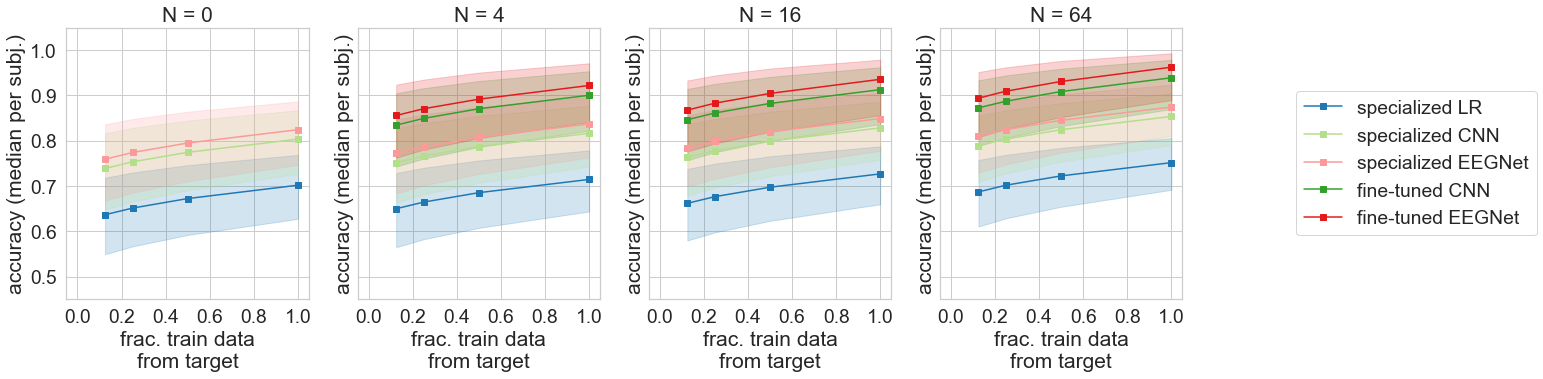

In [115]:
x_col = 'frac_of_target_subject_data_used_for_training'
y_col = 'acc_at_50th'
ylo_col = 'acc_at_10th'
yhi_col = 'acc_at_90th'

xticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
yticks = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

W = 5
H = 5

# These methods are CONSTANT with more target-specific data
generic_methods = OrderedDict()
generic_methods['generic LR'] = {'phases':'1+2', 'classifier_nickname':'LR'}
generic_methods['generic CNN'] = {'phases':'1+2', 'classifier_nickname':'CNN'}
generic_methods['generic EEGNet'] = {'phases':'1+2', 'classifier_nickname':'EEGNet'}

# These methods CHANGE with more target-specific data
specialized_methods = OrderedDict()
specialized_methods['specialized LR'] = {
    'color':chosen_colors[1],
    'phases':'3', 'classifier_nickname':'LR'}
specialized_methods['specialized CNN'] = {
    'color':chosen_colors[2],
    'phases':'3', 'classifier_nickname':'CNN'}
specialized_methods['specialized EEGNet'] = {
    'color':chosen_colors[4],
    'phases':'3', 'classifier_nickname':'EEGNet'}
specialized_methods['fine-tuned CNN'] = {
    'color':chosen_colors[3],
    'phases':'1+2+3', 'classifier_nickname':'CNN'}
specialized_methods['fine-tuned EEGNet'] = {
    'color':chosen_colors[5],
    'phases':'1+2+3', 'classifier_nickname':'EEGNet'}

N_grid = [0, 4, 16, 64]
_, axgrid = plt.subplots(nrows=1, ncols=len(N_grid), sharex=True, sharey=True, figsize=(W * len(N_grid), H))
axgrid = np.atleast_1d(axgrid)

for ii in range(len(N_grid)):
    ax = axgrid[ii]
    N = N_grid[ii]
    
    query_N_str = "n_generic_subjects_used_for_training == %d" % N
    specialized_at_N_df = df.query(query_N_str)

    # Unique legend name for each clf and phases combination
    for legend_name, S in specialized_methods.items():
        cur_df = specialized_at_N_df.query(
            "phases == '%s' and classifier_nickname == '%s'" % (
                S['phases'], S['classifier_nickname'])).reset_index().copy()
        assert cur_df.shape[0] == cur_df[x_col].unique().shape[0]
        
        row_ids = np.argsort(cur_df[x_col].values).tolist()
        
        x_vals = [cur_df.iloc[ii][x_col] for ii in row_ids]
        y_vals = [cur_df.iloc[ii][y_col] for ii in row_ids]
        ylo_vals = [cur_df.iloc[ii][ylo_col] for ii in row_ids]
        yhi_vals = [cur_df.iloc[ii][yhi_col] for ii in row_ids]
        
        ax.fill_between(x_vals, ylo_vals, yhi_vals, color=S['color'], alpha=0.2)
        ax.plot(x_vals, y_vals, 's-', label=legend_name, color=S['color'])
    
    
    B = 0.05
    ax.set_ylim([yticks[0]-B, yticks[-1]+B])
    ax.set_yticks(yticks)
    
    ax.set_xlim([xticks[0]-B, xticks[-1]+B])
    ax.set_xticks(xticks)

    ax.set_title('N = %d' % N)
    ax.set_xlabel('frac. train data\nfrom target')
    ax.set_ylabel('accuracy (median per subj.)')
    
    
    if ii == len(N_grid) - 1:
        ax.legend(bbox_to_anchor=(2.5, 0.8))

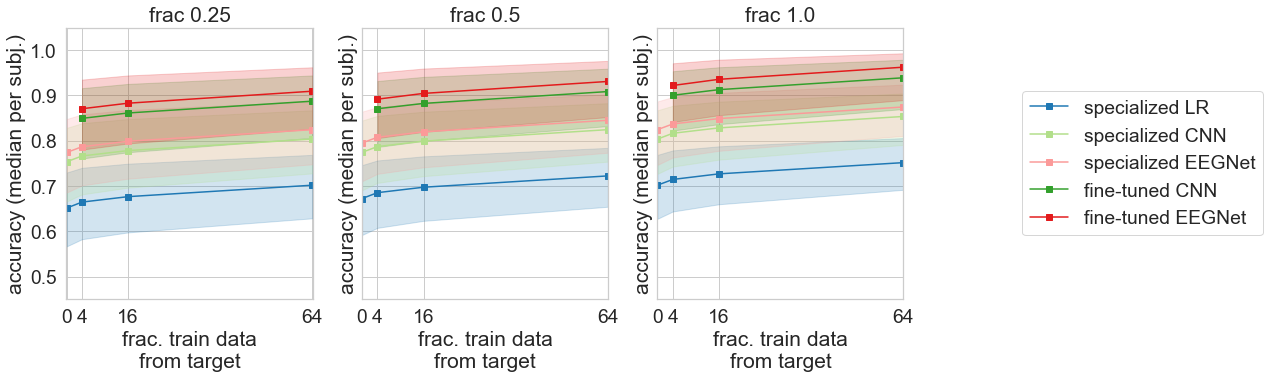

In [121]:
x_col = 'n_generic_subjects_used_for_training'
y_col = 'acc_at_50th'
ylo_col = 'acc_at_10th'
yhi_col = 'acc_at_90th'

xticks = [0, 4, 16, 64]
yticks = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

W = 5
H = 5

# These methods CHANGE with more target-specific data
specialized_methods = OrderedDict()
specialized_methods['specialized LR'] = {
    'color':chosen_colors[1],
    'phases':'3', 'classifier_nickname':'LR'}
specialized_methods['specialized CNN'] = {
    'color':chosen_colors[2],
    'phases':'3', 'classifier_nickname':'CNN'}
specialized_methods['specialized EEGNet'] = {
    'color':chosen_colors[4],
    'phases':'3', 'classifier_nickname':'EEGNet'}
specialized_methods['fine-tuned CNN'] = {
    'color':chosen_colors[3],
    'phases':'1+2+3', 'classifier_nickname':'CNN'}
specialized_methods['fine-tuned EEGNet'] = {
    'color':chosen_colors[5],
    'phases':'1+2+3', 'classifier_nickname':'EEGNet'}

frac_grid = [.25, 0.5, 1.0]
_, axgrid = plt.subplots(nrows=1, ncols=len(frac_grid), sharex=True, sharey=True, figsize=(W * len(frac_grid), H))
axgrid = np.atleast_1d(axgrid)

for ii in range(len(frac_grid)):
    ax = axgrid[ii]
    frac = frac_grid[ii]
    
    query_str = "frac_of_target_subject_data_used_for_training == %f" % frac
    specialized_df = df.query(query_str)

    # Unique legend name for each clf and phases combination
    for legend_name, S in specialized_methods.items():
        cur_df = specialized_df.query(
            "phases == '%s' and classifier_nickname == '%s'" % (
                S['phases'], S['classifier_nickname'])).reset_index().copy()
        assert cur_df.shape[0] == cur_df[x_col].unique().shape[0]
        
        row_ids = np.argsort(cur_df[x_col].values).tolist()
        
        x_vals = [cur_df.iloc[ii][x_col] for ii in row_ids]
        y_vals = [cur_df.iloc[ii][y_col] for ii in row_ids]
        ylo_vals = [cur_df.iloc[ii][ylo_col] for ii in row_ids]
        yhi_vals = [cur_df.iloc[ii][yhi_col] for ii in row_ids]
        
        ax.fill_between(x_vals, ylo_vals, yhi_vals, color=S['color'], alpha=0.2)
        ax.plot(x_vals, y_vals, 's-', label=legend_name, color=S['color'])
    
    
    B = 0.05
    ax.set_ylim([yticks[0]-B, yticks[-1]+B])
    ax.set_yticks(yticks)
    
    ax.set_xlim([xticks[0]-B, xticks[-1]+B])
    ax.set_xticks(xticks)

    ax.set_title('frac %s' % frac)
    ax.set_xlabel('frac. train data\nfrom target')
    ax.set_ylabel('accuracy (median per subj.)')
    
    if ii == len(frac_grid) - 1:
        ax.legend(bbox_to_anchor=(2.5, 0.8))